# Example notebook for dithering

This notebook demostrates the dithering process for a given source.
The script will probably be moved to a python project (out of the notebook) later.

In [1]:
# general packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.table

# specsim (DESI related packages)
import specsim
import specsim.quickspecsim as qspecsim
import specsim.instrument as inst
import specsim.source as src
import specsim.config as conf
import specsim.fiberloss as floss
import specsim.observation as obs
import specsim.simulator as sim
import specsim.atmosphere as atm

print('imports complete')

imports complete


In [2]:
# Create a simulator object using the given configuration
desi = sim.Simulator('/home/tyapici/Projects/DESI_projects/dithering/config/desi-blur.yaml')
print('desi-like model created')

desi-like model created


In [69]:
# function to generate the wavelength values
def create_wlen_grid(num_wlen=40, desi=desi):
    wavelength = desi.simulated['wavelength']
    wlen_unit = wavelength.unit
    return np.linspace(wavelength.data[0], wavelength.data[-1], num_wlen) * wlen_unit

# function to generate a single source
def generate_source(disk_fraction=0., bulge_fraction=0., vary='', seed=23, minormajor=[1,1]):
    gen = np.random.RandomState(seed)
    varied = vary.split(',')
    source_fraction = np.tile([disk_fraction, bulge_fraction], (1, 1))
    source_half_light_radius = np.tile([0.45, 1.0], (1, 1))
    source_minor_major_axis_ratio = np.tile(minormajor, (1, 1))
    if 'pa' in varied:
        source_position_angle = 360. * gen.uniform(size=(1, 2))
    else:
        source_position_angle = np.tile([0., 0.], (1, 1))
    return source_fraction, source_half_light_radius, source_minor_major_axis_ratio, source_position_angle

# function to create the object with galsim parameters
def calculateFiberLoss(wlen_grid, fiber_placement, desi=desi):
    calc = floss.GalsimFiberlossCalculator(desi.instrument.fiber_diameter.to(u.um).value,
                                           wlen_grid.to(u.Angstrom).value,
                                           num_pixels=16, oversampling=32, moffat_beta=3.5,
                                           fiber_placement=fiber_placement)
    return calc

def get_desimodel_fiberloss(obj_type='lrg'):
    path = os.path.join(os.environ['DESIMODEL'], 'data', 'throughput',
                        'fiberloss-{0}.dat'.format(obj_type))
    t = astropy.table.Table.read(path, format='ascii', names=['wlen', 'accept'])
    return t

def get_fiberloss(source_fraction, source_half_light_radius, source_minor_major_axis_ratio,
                  source_position_angle, x, y, calc, seeing=1.1*u.arcsec, desi=desi):
    # Subtract instrumental PSF.
    Jacoby = 0.219
    seeing = 2.35482 * np.sqrt((seeing.to(u.arcsec).value/2.35482) ** 2 - Jacoby**2) * u.arcsec
    # Tabulate seeing.
    desi.atmosphere.seeing_fwhm_ref = seeing
    seeing_fwhm = desi.atmosphere.get_seeing_fwhm(wlen_grid).to(u.arcsec).value
    # Calculate optics.
    scale, blur, offset = desi.instrument.get_focal_plane_optics(x, y, wlen_grid)
    # Do the fiberloss calculations.
    return calc.calculate(
        seeing_fwhm,
        scale.to(u.um / u.arcsec).value, offset.to(u.um).value,
        blur.to(u.um).value,
        source_fraction, source_half_light_radius,
        source_minor_major_axis_ratio, source_position_angle)

def generate_fiber_positions(nfiber=5000, seed=123, desi=desi):
    gen = np.random.RandomState(seed)
    focal_r = (
        np.sqrt(gen.uniform(size=nfiber)) * desi.instrument.field_radius)
    phi = 2 * np.pi * gen.uniform(size=nfiber)
    return np.cos(phi) * focal_r, np.sin(phi) * focal_r

In [70]:
# some constants
num_pixels = 32
oversampling = 32
wlen_grid = create_wlen_grid()
focal_x, focal_y = generate_fiber_positions(1)
source = generate_source()

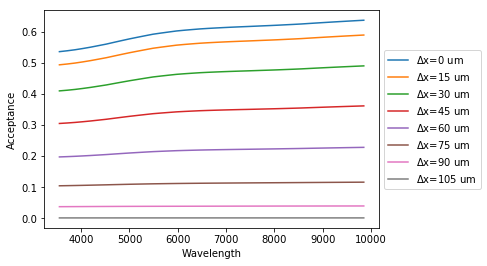

In [78]:
# first put the fiber in the middle with no dithering
GalsimCalculator = calculateFiberLoss(wlen_grid, [0., 0.], desi)
fiber_loss = get_fiberloss(*source, focal_x, focal_y, GalsimCalculator, desi=desi)
plt.plot(wlen_grid, fiber_loss.flatten(), label="$\Delta$x=0 um")
# then start moving the fiber until all the fiber is out
# we only move the fiber in x-direction here in increments of 15 um
for i in range(15, 120, 15):
    GalsimCalculator = calculateFiberLoss(wlen_grid, [i, 0], desi)
    fiber_loss = get_fiberloss(*source, focal_x, focal_y, GalsimCalculator, desi=desi)
    plt.plot(wlen_grid, fiber_loss.flatten(), label="$\Delta$x=%d um"%i)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Wavelength")
plt.ylabel("Acceptance")
plt.show()